In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from cnn_utils import denorm,generate_noisy_samples_from_image,img_show,logit_samples
from verif_utils import define_classification_polytope_w_b,generate_A_b,signed_distance_function

In [2]:
from nnSampleVerification import sdfs, verifMethods, plotter

In [3]:
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True
# Set random seed for reproducibility
torch.manual_seed(42)

In [4]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [5]:
# MNIST dataset and transform
mnist_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ]))

In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

CUDA Available:  False


In [7]:
# Initialize the network
model = Net().to(device)
# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device, weights_only=True))
# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [8]:
#load normalized image
norm_image, label = mnist_dataset[0]
norm_image = norm_image.unsqueeze(0)

In [9]:
label

7

In [10]:
#denormalize image
mean = torch.tensor([0.1307]).to(device)
std = torch.tensor([0.3081]).to(device)
image = denorm(norm_image,mean=mean, std=std)

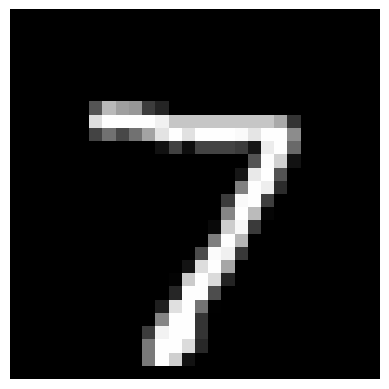

In [17]:
img_show(image,save_image = True,save_name = 'original_7.png')

In [12]:
#define transformation to be applied as required by nn
trans = transforms.Normalize((0.1307,), (0.3081,))

In [13]:
#standard deviation of noise
sd = 0.2

In [14]:
alpha = 0.5
epsilon = 0.1
verif1 = verifMethods.dkw(epsilon,alpha)

In [15]:
#generate noisy transformed images and corresponding nn output logits
noisy_samples,noisy_logits = logit_samples(image,model,trans,verif1.num_samples,sd)

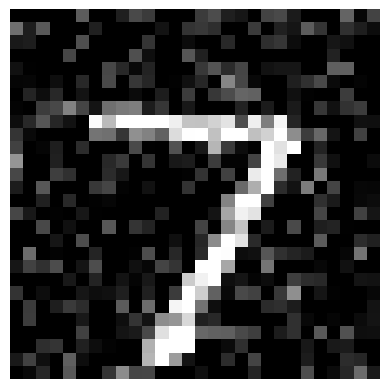

In [16]:
img_show(denorm(noisy_samples[0],mean=mean, std=std),save_image = True,save_name = 'noisy_7.png')

In [ ]:
denorm(noisy_samples[0],mean=mean, std=std).squeeze(0).permute(1, 2, 0).cpu().numpy().shape

In [ ]:
verif1.addSamples(noisy_logits)

In [ ]:
#Defining polytope for given class index
W,B = define_classification_polytope_w_b(noisy_logits[0],label)

In [ ]:
class NN_SDF:
    def __init__(self,W,B):
        self.W = W
        self.B = B

    def reviseCenter(self,W,B):
        self.W = W
        self.B = B

    def eval(self, point, zero_radius):
        # Replace this with your actual signed distance function implementation
        eval = np.array([signed_distance_function(l,self.W,self.B) for l in point]) - zero_radius 
        return eval

In [ ]:
SDF = NN_SDF(W,B)
verif1.addSpecification(SDF)

In [ ]:
# Run ZeroOne
verif1.findZeroOne()
print(verif1.zeroOne)

In [ ]:
levelProb = 0.999
levelSetZeroRadius = verif1.findLevelSet(levelProb)

In [ ]:
print(levelSetZeroRadius)
print(verif1.empiricalCDFGen(levelSetZeroRadius))

In [ ]:
#nn labels for noisy inputs
s_labels = [np.argmax(l) for l in noisy_logits]